# Hyperparameter optimization workflow

Author: Bogdan Tsal-Tsalko

Version Date: 01/22/2023

## Overview

This notebook and the functions in 'helpers.py' provide a repeatable framework for executing hyperparameter search via DataRobot's Python client.

### Hyperparameters for DataRobot modeling

In machine learning, hyperparameter tuning is the act of adjusting the "settings" (referred to as hyperparameters) in a machine learning algorithm, whether that's the learning rate for an XGBoost model or the activation function in a neural network. Many methods for doing this exist, with the simplest being a brute force search over every feasible combination. While this requires little effort, it's extremely time-consuming as each combination requires fitting the machine learning algorithm. To this end, practitioners strive to find more efficient ways to search for the best combination of hyperparameters to use in a given prediction problem. DataRobot employs a proprietary version of [pattern search](https://app.datarobot.com/docs/modeling/analyze-models/evaluate/adv-tuning.html#set-the-search-type) for optimization not only for the machine learning algorithm's specific hyperparameters, but also the *respective data preprocessing needed to fit the algorithm*, with the goal of quickly producing high-performance models tailored to your dataset.  

While the approach used at DataRobot is sufficient in most cases, you may want to build upon DataRobot's Autopilot modeling process by custom tuning methods. In this AI Accelerator, you will familiarize yourself with DataRobot's fine-tuning API calls to control DataRobot's pattern search approach as well as implement a modified brute-force gridsearch for the text and categorical data pipeline and hyperparameters of an XGBoost model. This notebook serves as an introductory learning example that other approaches can be built from.  Bayesian Optimization, for example, leverages a probabilistic model to judiciously sift through the hyperparameter space to converge on an optimal solution, and will be presented next in this accelerator bundle.

Note that as a best practice, it is generally best to wait until the model is in a near-finished state before searching for the best hyperparameters to use. Specifically, the following have already been finalized:

- Training data (e.g., data sources)
- Model validation method (e.g., group cross-validation, random cross-validation, or backtesting. How the problem is framed influences all subsequent steps, as it changes error minimization.)
- Feature engineering (particularly, calculations driven by subject matter expertise)
- Preprocessing and data transformations (e.g., word or character tokenizers, PCA, embeddings, normalization, etc.)
- Algorithm type (e.g. GLM, tree-based, neural net)

These decisions typically have a larger impact on model performance compared to adjusting a machine learning algorithm's hyperparameters (especially when using DataRobot, as the hyperparameters chosen automatically are pretty competitive).  

### Problem set-up

You have settled on a near-final model, and getting that last extra bit of performance matters for your use case. You want to perform a more exhaustive search, or perhaps as an advanced data scientist you have certain parameters you'd like to experiment with. 

### Advanced tuning and gridsearch approach

This notebook helps you learn how to access, understand, and tune blueprints for both preprocessing and model hyperparameters. You'll programmatically work with DataRobot [advanced tuning](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/adv-tuning.html) which you can then adapt to your other projects.

You'll learn how to:

* Prepare for tuning a model via the DataRobot API
    - Load a project and model for tuning
    - Set the validation type for minimizing error
    - Extracting model metadata
    - Get model performance
    - Review hyperparameters
* Run a single advanced tuning session
* Implement your own custom gridsearch for single and multiple models to evaluate

    
### Prerequsites

- A completed DataRobot project (example data can be accessed here: [API](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.25.1/examples/lending_club/Predicting_Bad_Loans.html) and a [notebook](https://docs.datarobot.com/en/docs/api/guide/common-case/loan-default/loan-default-nb.html)).

- Review requirements.txt

## Setup

### Import libraries

In [2]:
import datarobot as dr
from datarobot.errors import AsyncProcessUnsuccessfulError, JobNotFinished
from datarobot.models.job import Job
import graphviz
from helpers import *
import pandas as pd

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [3]:
dr.Client()

### Optional: create a project

Create a project from a URL in DataRobot and follow the cell below.

In [ ]:
%%time
url = "https://s3.amazonaws.com/datarobot_public_datasets/10K_Lending_Club_Loans.csv"
project = dr.Project.create(url, project_name="Loan_default_hyperopt")
print("Project ID: {}".format(project.id))
project.analyze_and_model(
    target="is_bad",
    worker_count=-1,
    mode=dr.enums.AUTOPILOT_MODE.FULL_AUTO,
)
project.wait_for_autopilot(verbosity=dr.enums.VERBOSITY_LEVEL.SILENT)

## Prepare for tuning a model

### Select a model

To start tuning, select the model you want to tune from an existing DataRobot project. Your project ID and model ID might be accessed through the API via `dr.Project.list(search_params=({'project_name':'YOUR_SEARCH_KEY'}))`, or simply from the URL of your project.  Alternatively, the helper function below returns a summary of the Leaderboard for a given project.

In [6]:
# To access an existing project set your project ID below
# project = dr.Project.get("project_id_see_example_below")

print("Project URL: " + "https://app.datarobot.com/projects/" + project.id + "/eda")
print("Project ID: " + project.id)

leaderboard_top = get_top_of_leaderboard(project, metric="LogLoss")

Project URL: https://app.datarobot.com/projects/63dd8d10a2633602cfeb80d1/eda
Project ID: 63dd8d10a2633602cfeb80d1
Unique blueprints tested: 39
Feature lists tested: 2
Models trained: 65
Blueprints in the project repository: 280
Feature engineering and preprocessing steps ran:  2455


Top models in the leaderboard:


,model_id,model,pct,validation_LogLoss,cross_validation_LogLoss
0,63dd8e84f8dd7f9f66de9c1c,Light Gradient Boosted Trees Classifier with E...,64.0,0.36734,0.357414
1,63dd8e84f8dd7f9f66de9c20,eXtreme Gradient Boosted Trees Classifier with...,64.0,0.36780,0.357710
2,63dd8e84f8dd7f9f66de9c1b,eXtreme Gradient Boosted Trees Classifier with...,64.0,0.36571,0.357786
3,63dd8e84f8dd7f9f66de9c1d,Gradient Boosted Trees Classifier with Early S...,64.0,0.36608,0.357796
4,63dd8fe5cbfcbbaaec9043b2,Light Gradient Boosted Trees Classifier with E...,64.0,0.36827,0.357800


The example cell below retrieves the XGBoost blueprint with Unsupervised Learning Features, which will be used in this notebook.

In [4]:
bp_from_search = [
    bp
    for bp in project.get_blueprints()
    if "Unsupervised Learning Features" in bp.model_type
][
    0
].id  # search the blueprint repository

model = Job.get(
    project_id=project.id,
    job_id=project.train(
        bp_from_search
    ),  # train the blueprint or get the model results
).get_result_when_complete()

Alternative approach to select a model from the top models output.  

In [7]:
model = dr.Model.get(
    project=project.id,
    model_id=leaderboard_top.iloc[
        2
    ][  # Select a model from the top-performing models in the Leaderboard
        "model_id"
    ],
)
model

Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features')

### Inspect a blueprint

Before you start tuning, it is conceptually important to reiterate what is contained within a blueprint. In addition to the learning algorithm hyperparmeters, you also have the option to experiment with the hyperparameters of the tasks prior to the learner. 

For more information please visit the documentation on [blueprints](https://docs.datarobot.com/en/docs/modeling/analyze-models/describe/blueprints.html). 

You can visualize the processes for your selected model using the cell below to generate a chart.

BlueprintChart(24 nodes, 31 edges)


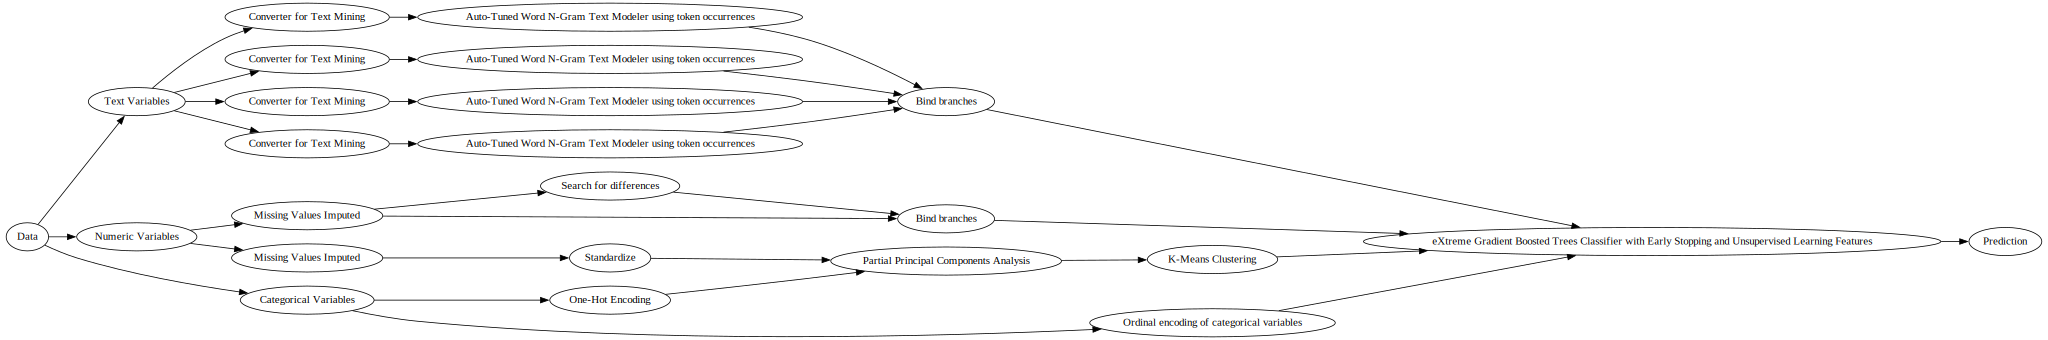

In [8]:
bpChart = model.blueprint.get_chart()
print(bpChart)
src = graphviz.Source(bpChart.to_graphviz())
src

To further understand what is happening above:

- Each of the four text variables in the feature list used by the model is being passed through an Auto-Tuned Word N-Gram Text Modeler, which fits a single-word n-gram model to each text feature in the input dataset, then use the predictions from these models as inputs to an ElasticNet classifier. Further post-processing optimizes the weights of the text-vector via grid search.

- Numeric variables go through two paths:
    - A greedy search for differences between columns to identify new features.
    - Standardizaztion by removing the median and scaling to unit variance or mean absolute deviation. Scaled features are combined with one-hot encoded categoricals, which produces a wide matrix that is fed into PCA, then into k-means to identify clusters of latent features.
    
- Categoricals go through the above path into PCA, as well as through ordinal encoding in a separate path.

Each of these paths are fed in to XGBoost. You can also access documentation around each process using the cell below.

In [9]:
bpDoc = model.blueprint.get_documents()[-1]
print("references for {}:", format(bpDoc.task))
for (i, link) in enumerate(bpDoc.links):
    print("{} - {}: {}".format(i, link["name"], link["url"]))

references for {}: Truncated SVD tasks
0 - sklearn TruncatedSVD: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
1 - sklearn decomposition (matrix factorization) user guide: http://scikit-learn.org/stable/modules/decomposition.html#lsa


In [10]:
print("model type: {}".format(model.model_type))
print("processes:")
for (i, p) in enumerate(model.blueprint.processes):
    print("{} - {}".format(i, p))

model type: eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features
processes:
0 - Ordinal encoding of categorical variables
1 - Missing Values Imputed
2 - Search for differences
3 - Converter for Text Mining
4 - Auto-Tuned Word N-Gram Text Modeler using token occurrences
5 - Standardize
6 - One-Hot Encoding
7 - Partial Principal Components Analysis
8 - K-Means Clustering
9 - eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features


### Extract tunable parameters as a dataframe. 

The function below returns all hyperparameters as a dataframe. Note- text pipelines are applied to each column of text, thus duplicate parameter names can exist.  `Keep duplicates=False` hides these parameters.

In [11]:
parameters_to_df(model.get_advanced_tuning_parameters(), keep_duplicates="first")

,task_name,parameter_name,parameter_name_type,current_value,default_value,param_type,supports_grid_search,min,max,values,parameter_id
0,Auto-Tuned Word N-Gram Text Modeler using toke...,analyzer,analyzer_select,word,word,select,NaN,NaN,NaN,"[word, char]",eyJhcmciOiJhbmFseXplciIsInZpZCI6IjEwIn0
24,Auto-Tuned Word N-Gram Text Modeler using toke...,min_df,min_df_int,2,2,int,False,0.0000,1000000000000000019884624838656,NaN,eyJhcmciOiJtaW5fZGYiLCJ2aWQiOiI2In0
51,Auto-Tuned Word N-Gram Text Modeler using toke...,use_marisa,use_marisa_select,True,True,select,NaN,NaN,NaN,"[False, True]",eyJhcmciOiJ1c2VfbWFyaXNhIiwidmlkIjoiOCJ9
27,Auto-Tuned Word N-Gram Text Modeler using toke...,min_tc,min_tc_int,0,0,int,False,0.0000,999,NaN,eyJhcmciOiJtaW5fdGMiLCJ2aWQiOiI2In0
31,Auto-Tuned Word N-Gram Text Modeler using toke...,n_features,n_features_int,262144,262144,int,False,1.0000,1048576,NaN,eyJhcmciOiJuX2ZlYXR1cmVzIiwidmlkIjoiMTIifQ
32,Auto-Tuned Word N-Gram Text Modeler using toke...,norm,norm_select,l2,l2,select,NaN,NaN,NaN,"[None, l1, l2]",eyJhcmciOiJub3JtIiwidmlkIjoiMTAifQ
38,Auto-Tuned Word N-Gram Text Modeler using toke...,segmenter,segmenter_select,None,None,select,NaN,NaN,NaN,"[None, japanese]",eyJhcmciOiJzZWdtZW50ZXIiLCJ2aWQiOiI4In0
39,Auto-Tuned Word N-Gram Text Modeler using toke...,smooth_idf,smooth_idf_select,True,True,select,NaN,NaN,NaN,"[False, True]",eyJhcmciOiJzbW9vdGhfaWRmIiwidmlkIjoiMTAifQ
41,Auto-Tuned Word N-Gram Text Modeler using toke...,stop_words,stop_words_select,0,0,select,NaN,NaN,NaN,"[False, True, english]",eyJhcmciOiJzdG9wX3dvcmRzIiwidmlkIjoiMTAifQ
42,Auto-Tuned Word N-Gram Text Modeler using toke...,sublinear_tf,sublinear_tf_select,False,False,select,NaN,NaN,NaN,"[False, True]",eyJhcmciOiJzdWJsaW5lYXJfdGYiLCJ2aWQiOiI2In0


## Run an advanced tuning session

The blueprint processes shown above are available as tunable tasks. To perform a hyperparameter search, you must first instantiate an advanced tuning session on your selected model. You will run a single tuning session below.

The example below: 
- Starts and advanced Tuning Session
- Lists the tunable tasks (the first column in the dataframe above)
- Executes a tuning job on the `colsample_bytree` and `learning_rate_float` hyperparameters on the learning algorithm

### Create an advanced tuning session

In [12]:
ATS = dr.models.advanced_tuning.AdvancedTuningSession(model)

In [13]:
tasks = ATS.get_task_names()
tasks
# ATS.get_parameter_names(tasks[2])

['Auto-Tuned Word N-Gram Text Modeler using token occurrences',
 'K-Means Clustering',
 'Missing Values Imputed',
 'One-Hot Encoding',
 'Ordinal encoding of categorical variables',
 'Partial Principal Components Analysis',
 'eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features']

In [14]:
ATS.set_parameter(parameter_name="colsample_bytree", value=0.4)
ATS.set_parameter(parameter_name="learning_rate", value=0.045)
job = ATS.run()
tuned_model = job.get_result_when_complete()
{model.project.metric: tuned_model.metrics[model.project.metric]}

{'LogLoss': {'validation': 0.36724,
  'crossValidation': 0.357612,
  'holdout': None,
  'training': None,
  'backtestingScores': None,
  'backtesting': None}}

## Hyperparameter tuning with grid search

The approach above is sufficient for modifying exact values, and now you'll expand to a custom grid search. In DataRobot, grid searching hyperparameters can be done in two ways:

1. Testing multiple hyperparameter combinations within a single model

   - Uses internal partition for hyperparameter selection (note: these are not the Leaderboard partitions)
   - Uses DataRobot's proprietary version of [pattern search](https://app.datarobot.com/docs/modeling/analyze-models/evaluate/adv-tuning.html#set-the-search-type) for optimization
   - Useful if:
       * You want hyperparameters to be chosen using the project metric
       * You don't want the Leaderboard partitions to be used for hyperparameter selection (best practice and default behavior for DataRobot)
       
   
2. Testing multiple hyperparameter combinations with multiple models

   - Uses a leaderboard partition for hyperparameter selection
   - Can use any optimization strategy of interest (e.g., brute force, Bayesian Optimization, etc.)
   - Useful if:
       1. You want hyperparameters to be chosen based on a Leaderboard (or custom) metric
       2. You want to use a Leaderboard partition for hyperparameter selection (be sure to use a different partition for model evaluation)
       3. You want to search over hyperparameters that _do not_ accept one or more values (see [docs](https://app.datarobot.com/docs/modeling/analyze-models/evaluate/adv-tuning.html#set-a-parameter)) 

### Option 1: Grid search internally with pattern search model

In [15]:
%%time
# Option (1)
ATS = dr.models.advanced_tuning.AdvancedTuningSession(model)
ATS.set_parameter(parameter_name="subsample", value=[0.5, 0.7, 1])
ATS.set_parameter(parameter_name="colsample_bytree", value=[0.4, 0.6, 0.8, 1])
ATS.set_parameter(parameter_name="max_depth", value=[4, 6, 8, 10])
job = ATS.run()
tuned_model = job.get_result_when_complete()
{model.project.metric: tuned_model.metrics[model.project.metric]}

# See the best values
tuned_hyperparameters = tuned_model.get_advanced_tuning_parameters()[
    "tuning_parameters"
]
for hp in ["subsample", "colsample_bytree", "max_depth"]:

    hp_values = [x for x in tuned_hyperparameters if x["parameter_name"] == hp][0]
    print(f"{hp}: {hp_values['default_value']}")

subsample: 0.5
colsample_bytree: 0.4
max_depth: 4
CPU times: user 187 ms, sys: 21.7 ms, total: 209 ms
Wall time: 1min 10s


### Option 2: Brute force grid search with one model per combination on project validation data 

In [16]:
%%time
# Option (2)
# Tuning over same grid
validation_type = "validation"

tuning_hyperparameters(
    model=model,
    advanced_tuning_grid={
        "subsample": [0.5, 0.7, 1],
        "colsample_bytree": [0.4, 0.6, 0.8, 1],
        "max_depth": [4, 6, 8, 10],
    },
    partition=validation_type,
    metric=None,  # Will default to project metric
    max_n_models_to_keep=5,
)

Number of hyperparameter combinations to evaluate: 48
Waiting for 48 models...
48 completed successfully!
Deleting 43 of 48 models...
Model deletion finished!
CPU times: user 4.04 s, sys: 510 ms, total: 4.55 s
Wall time: 8min 58s


### Extra credit

In [17]:
# Tuning over a hyperparameter that cannot accept more than 1 value
try:

    ATS = dr.models.advanced_tuning.AdvancedTuningSession(model)
    ATS.set_parameter(parameter_name="smooth_interval", value=[50, 100, 200])
    job = ATS.run()

except Exception as error:

    print(error)
    print("\n")

# Can tune over this hyperparameter here because 3 different models will be built
tuning_hyperparameters(
    model=model,
    advanced_tuning_grid={"smooth_interval": [50, 100, 200]},
    partition=validation_type,
    metric=None,
    max_n_models_to_keep=5,
)

422 client error: {'message': 'Only one value allowed for this parameter'}


Number of hyperparameter combinations to evaluate: 3
Waiting for 3 models...
3 completed successfully!


## Tuning over preprocessing steps and model hyperparameters

The cell below applies the brute force approach to multiple steps in the modeling pipeline.

In [19]:
%%time
# Tuning over a mix of preprocessing and model hyperparameters
tuning_hyperparameters(
    model=model,
    advanced_tuning_grid={
        "method": ["resp", "freq", "lex"],  # ordinal encoding
        "binary": [True, False],  # text pipeline
        "analyzer": ["word", "char"],  # text pipeline
        "tree_method": ["exact", "approx", "hist"],
        "max_depth": [4, 6, 8, 10],
    },
    partition="validation",
    metric=None,
    max_n_models_to_keep=5,
)

Number of hyperparameter combinations to evaluate: 144
Waiting for 144 models...
144 completed successfully!
Deleting 139 of 144 models...
Model deletion finished!
CPU times: user 10.4 s, sys: 1.24 s, total: 11.6 s
Wall time: 20min 50s


`get_tuned_parameters` returns the original model from the beginning of the notebook at index 0, and then the other tuned runs for comparison, along with the parameters that differed from the original model in each subsequent run. Below we sort by loss, so we can see that one run showed improvement over our initial model (index 0)

In [26]:
tuned_param = get_tuned_parameters(project, model, validation_type)
tuned_param.sort_values(by="validation").head()

Similar models found:  14


,model_id,colsample_bytree_float,learning_rate_float,max_depth_int,method_select,smooth_interval_int,subsample_float,tree_method_select,validation
3,63ddc6d4c95ec74fc19be627,0.4,0.05,4,freq,200,0.7,auto,0.3654
0,63dd8e84f8dd7f9f66de9c1b,0.3,0.05,3,freq,200,1,auto,0.36571
8,63ddc8be043a16aed62addb0,0.3,0.05,3,freq,50,1,auto,0.36571
9,63ddc8c136df624f4811143d,0.3,0.05,3,freq,100,1,auto,0.36571
10,63ddc8c42e5a3f329211152d,0.3,0.05,3,freq,200,1,auto,0.36571


In [91]:
# Return the max improvement by partition from all tunes


def perc_imp(df, model, val="validation"):
    out = ((df.loc[df["model_id"] == model.id][val] / df[val].min()) - 1) * 100
    return round(out[0], 4)


# Return the total number of tunes that performed better than the base model by partition


def num_improved(df, val="validation"):
    out = df[df[val] < df.loc[0][val]].shape[0]
    return out

In [82]:
print(
    num_improved(tuned_param),
    " of the tuning runs improved over the baseline run from the project, with the best tune yielding",
    perc_imp(tuned_param, model),
    "% improvement on validation, which is in line with the gains we discussed at the beginning",
)

1  of the tuning runs improved over the baseline run from the project, with the best tune yielding 0.0848 % improvement on validation, which is in line with the gains we discussed at the beginning


Note the neglible improvement from the search space provided. Learning rate was left out previously--explore that below.  

In [61]:
#%%time
# Add learning rate to search space
validation_type = "validation"

tuning_hyperparameters(
    model=model,
    advanced_tuning_grid={
        "learning_rate": [0.02, 0.03, 0.04],
        "subsample": [0.5, 0.7],
        "colsample_bytree": [0.4, 0.6],
        "max_depth": [4, 6],
    },
    partition=validation_type,
    metric=None,  # Will default to project metric
    max_n_models_to_keep=5,
)

Number of hyperparameter combinations to evaluate: 24
Waiting for 24 models...
24 completed successfully!
Deleting 19 of 24 models...
Model deletion finished!


In [92]:
# Check results after last tune
tuned_param2 = get_tuned_parameters(project, model, validation_type)
print(perc_imp(tuned_param2, model), "% improvement")
print(num_improved(tuned_param2), " model with less error than the base model")

Similar models found:  19
0.0848 % improvement
1  model with less error than the base model


In [93]:
# Evaluate performance on cross-validation of tuned-models
tuned_param3 = get_tuned_parameters(project, model, "crossValidation")
print(perc_imp(tuned_param3, model, val="crossValidation"), "% improvement")
print(
    num_improved(tuned_param3, val="crossValidation"),
    " model with less error than the base model",
)

Similar models found:  19
0.291 % improvement
11  model with less error than the base model


After 100+ runs, there was close to neglible improvement over our baseline model.  We can see that the large experiment tuning over the text pipeline with binarization, word/character encoding, and alternative ordinal encodings for the categoricals didn't make a difference, and that can give us confidence in that specific part of the original model pipeline. It is also a nod towards the heuristics and pattern search approach employed out of the box with DataRobot. 

At the same time, we only evaluated a few settings in this example. Approaches that leverage hyperparameter sampling across a range of continuous features, random search methods, as well as your own preferred tuning approaches are other options you can implement from the code provided here. 

## Conclusion

The steps above provide a repeatable process for accessing and tuning DataRobot models, as well as introduce concepts around Blueprint creation and selection. 

An additional brute force grid search was presented, which enables you to tune based on the project or a custom metric.  A modest lift of <1% on validation and cross-validation was achieved, which is in line with the heuristic presented at the beginning where hyperparameter tuning often yields in the low single digit percent improvements in error. Another takeaway with this approach is that there is no incremental learning occurring between tuning rounds, and performance is limited to user knowledge of hyperparameter values. 

In practice, if you know the parameters you want to try, a simple brute force approach or pattern search implemented by DataRobot works fine. However, the increased computation and time associated with having one model to evaluate each combination. This obviously explodes across a wide search space, and is not optimized for computation or time. When those two constraints matter, approaches such as Bayesian Optimization can be beneficial.